# Imports


In [52]:
%pip install scipy==1.11.4


Note: you may need to restart the kernel to use updated packages.


In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

import scikitplot as skplt
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics as mt
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


# Helper Functions

In [54]:
def precision_at_k( df, perc) :

    k=int(np.floor(len(df)*perc))

    df = df.reset_index( drop=True )
    df['ranking'] = df.index + 1
    
    df['precision_at_k'] = df['response'].cumsum() / df['ranking']
    
    return ( df.loc[ k, 'precision_at_k'])

def recall_at_k( df, perc ):

    k=int(np.floor(len(df)*perc))
    
    df = df.reset_index( drop=True )
    df['ranking'] = df.index + 1
    
    df['recall_at_k'] = df['response'].cumsum() / df['response'].sum()
    
    return ( df.loc[ k, 'recall_at_k'])

def calculateMetrics (model_name, yhat, x_val, y_val):
    df = x_val.copy()
    df['response'] = y_val.copy()

    # propensity score
    df['score'] = yhat[:, 1].tolist()

    # sort clients by propensity score
    df = df.sort_values( 'score', ascending=False )

    # compute precision at k 
    precision_at = precision_at_k(df,0.2)
    
    # compute recall at k
    recall_at = recall_at_k(df,0.2)
    
    roc_auc = mt.roc_auc_score(y_val, yhat[:,1])
    
    return metrics(model_name, precision_at,recall_at,roc_auc)

def metrics(model_name,precision_at_k,recall_at_k,roc_auc):

    return pd.DataFrame({'Model Name': model_name,
                        'Precision_at_k': precision_at_k,
                        'Recall_at_k': recall_at_k,
                        'Roc_auc': roc_auc}, index=[0])

# Load Datasets


In [55]:
df = pd.read_csv('../data/train/train.csv')

df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# Data Description

In [56]:
df.describe()

,id,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


In [58]:
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [59]:
sns.set_theme(style="darkgrid")

# Feature Engineering

In [60]:
df.columns

Index(['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response'],
      dtype='object')

In [61]:
news_cols = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

df.columns = news_cols
(df['vehicle_age'].unique())

array(['> 2 Years', '1-2 Year', '< 1 Year'], dtype=object)

In [62]:
df.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [63]:
df['vehicle_age'] = df['vehicle_age'].apply(lambda x: 'over_2_years' if x== '> 2 Years'
                                            else 'between_1_2_year' if x == '1-2 Year'
                                            else 'below_1_year' )

df['vehicle_damage'] = df['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)


In [64]:
df.head(10)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,over_2_years,1,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,between_1_2_year,0,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,over_2_years,1,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,below_1_year,0,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,below_1_year,0,27496.0,152.0,39,0
5,6,Female,24,1,33.0,0,below_1_year,1,2630.0,160.0,176,0
6,7,Male,23,1,11.0,0,below_1_year,1,23367.0,152.0,249,0
7,8,Female,56,1,28.0,0,between_1_2_year,1,32031.0,26.0,72,1
8,9,Female,24,1,3.0,1,below_1_year,0,27619.0,152.0,28,0
9,10,Female,32,1,6.0,1,below_1_year,0,28771.0,152.0,80,0


# Data Filtering

# EDA

In [65]:
df2 = df.copy()

In [66]:
df2[['response']].value_counts(normalize=True).reset_index()

,response,proportion
0,0,0.877437
1,1,0.122563


## Univariate Analysis

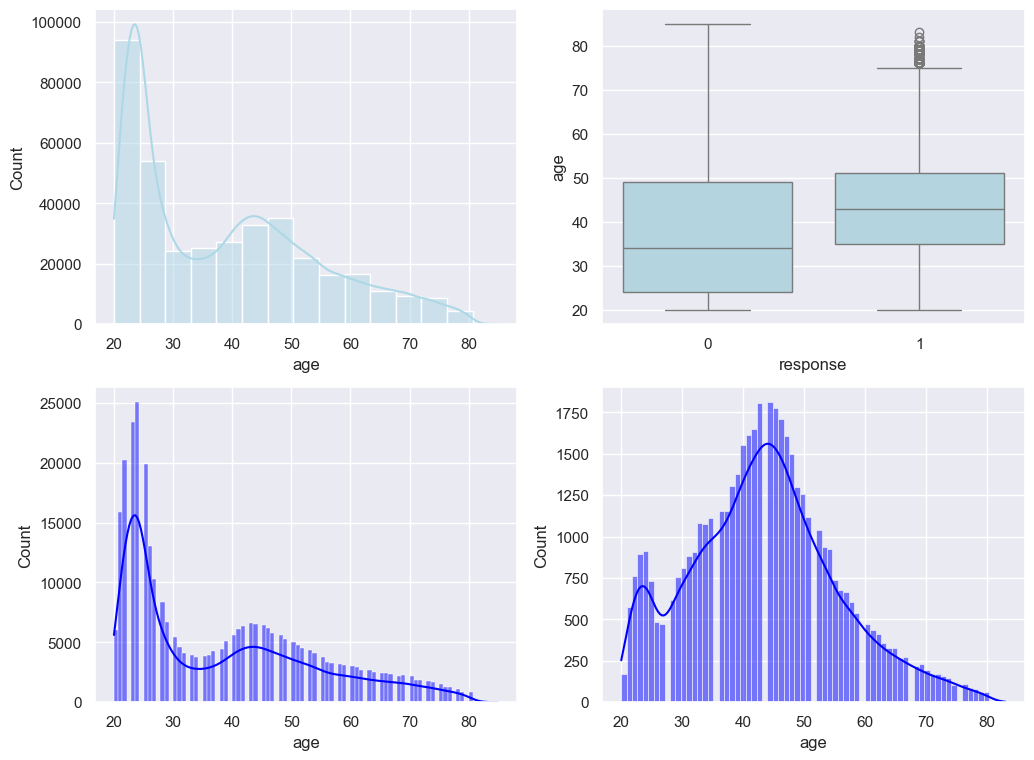

In [67]:
# Age
# histograma do Age e relação entre Age e o response
aux0 = df2.loc[df2['response'] == 0, 'age']
aux1 = df2.loc[df2['response'] == 1, 'age']
fig, ax = plt.subplots(2, 2, figsize=(12, 9))
sns.histplot(df2['age'], bins=15, kde=True, color='lightblue', ax=ax[0][0])
sns.boxplot(x='response', y='age', data=df2, color='lightblue', ax=ax[0][1])

sns.histplot(aux0, kde=True, color='blue',ax=ax[1][0])
sns.histplot(aux1, kde=True, color='blue', ax=ax[1][1])
plt.show()


### Idade influencia na contratação ou não de seguro. Idade média de 45 anos contrata mais.
---


<Axes: xlabel='annual_premium', ylabel='Count'>

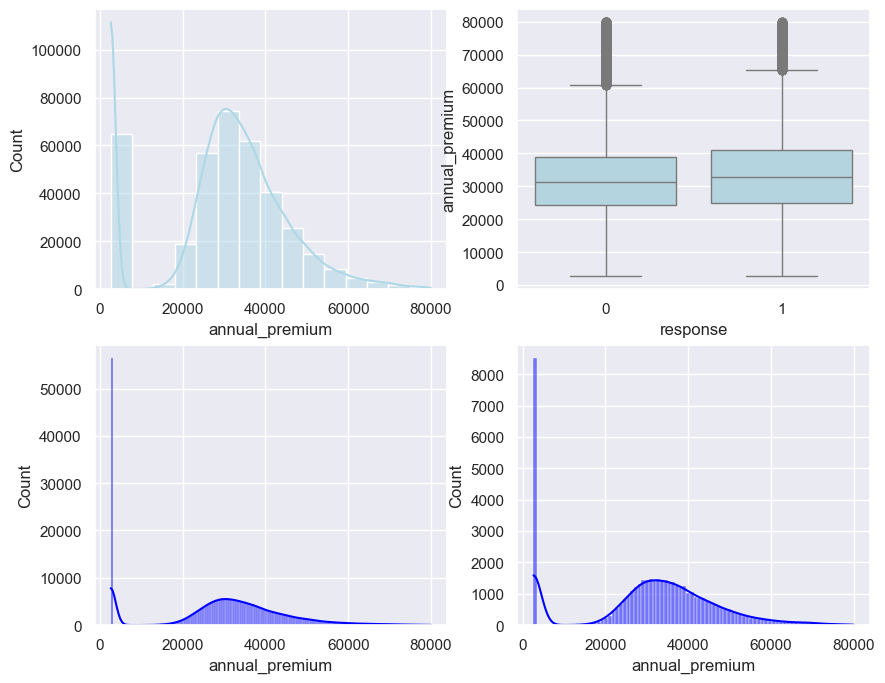

In [20]:
# Annual premium
aux = df2[df2['annual_premium'] < 80000] #apenas para ser mais visual
aux0 = aux.loc[aux['response'] == 0, 'annual_premium']
aux1 = aux.loc[aux['response'] == 1, 'annual_premium']
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
sns.histplot(aux['annual_premium'], bins=15, kde=True, color='lightblue', ax=ax[0][0])
sns.boxplot(x='response', y='annual_premium', data=aux, color='lightblue', ax=ax[0][1])

sns.histplot(aux0, kde=True, color='blue',ax=ax[1][0])
sns.histplot(aux1, kde=True, color='blue', ax=ax[1][1])



### Não há diferença na distribuição com base no annual_premium
---

,driving_license,proportion
0,1,0.997869
1,0,0.002131


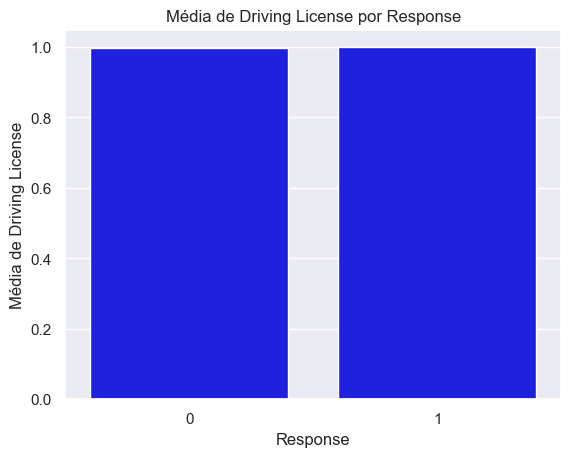

In [19]:
# drivers license

aux = df2[['driving_license', 'response']].groupby('response').mean().reset_index()

# Criar o gráfico de barras
sns.barplot(x='response', y='driving_license', color='blue', data=aux)

# Adicionar títulos e rótulos, se necessário
plt.title('Média de Carteira de Motorista por Response')
plt.xlabel('Response')
plt.ylabel('Média de Driving License')

# Exibir o gráfico
plt.show()


### Não informa muita coisa. A maioria que não contrata TEM carteira de motorista.
---

<Axes: xlabel='region_code', ylabel='id'>

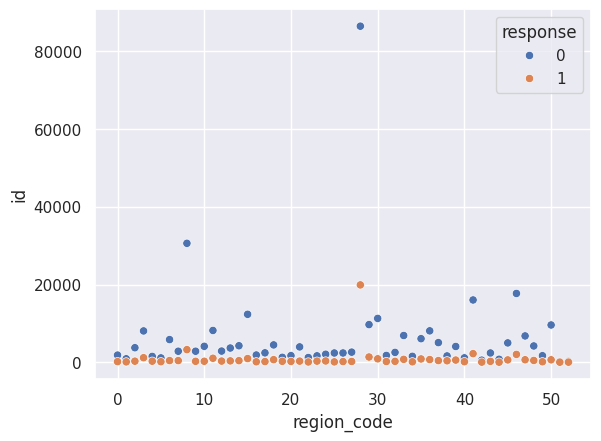

In [17]:
# region
aux = df2[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x = 'region_code', y='id', hue='response', data=aux)


### não informa nenhuma relação com a variável response
---

In [18]:
# previously_insured

pd.crosstab(df2['previously_insured'], df2['response'])

response,0,1
previously_insured,,
0,159929,46552
1,174470,158


### não indica muito, pois o resultado reflete que quem já tem não quer outro seguro.
### pela discrepancia, pode ser uma variável complicada para mostrar ao modelo, pois ele vai encontrar uma forte correlação sem informar muito.
---

In [21]:
#vehicle_age
filtered_df = df2[df2['response'] == 1]
filtered_df[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,proportion
0,between_1_2_year,1,0.745151
1,below_1_year,1,0.154185
2,over_2_years,1,0.100664


### para carros muito novos a discrepância também é muito grande. Podendo vazar para o modelo.

<Axes: xlabel='response', ylabel='policy_sales_channel'>

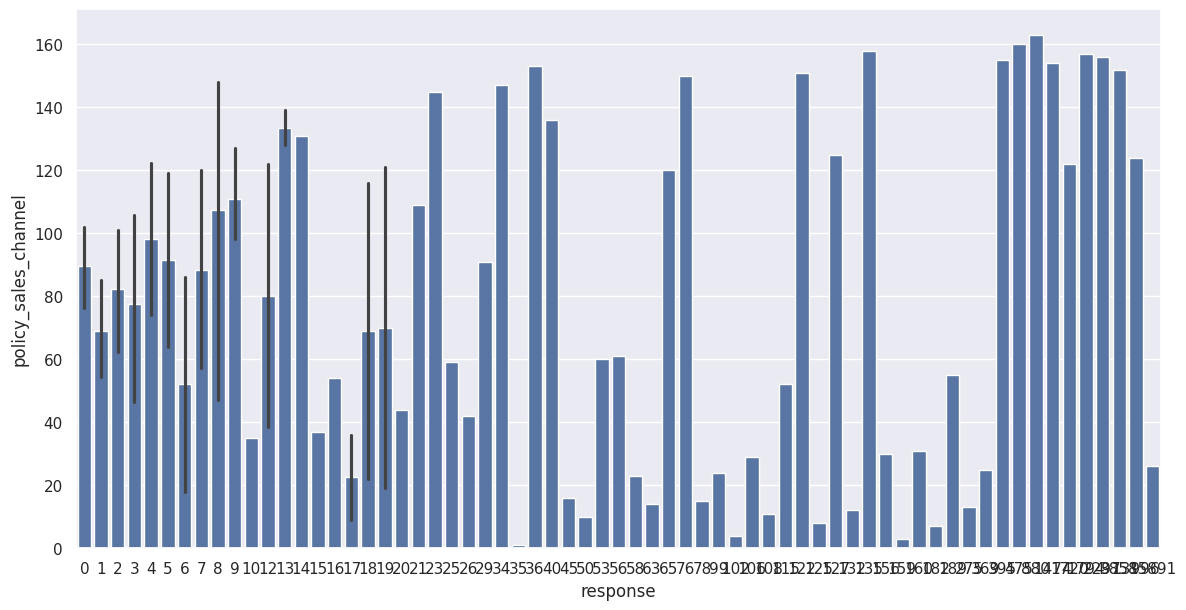

In [20]:
#policy_sales_channel
aux = df2[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(x='response', y='policy_sales_channel', data=aux)

### Mostra relação de contratação pelo canal escolhido para contato
---

<Axes: xlabel='response', ylabel='vintage'>

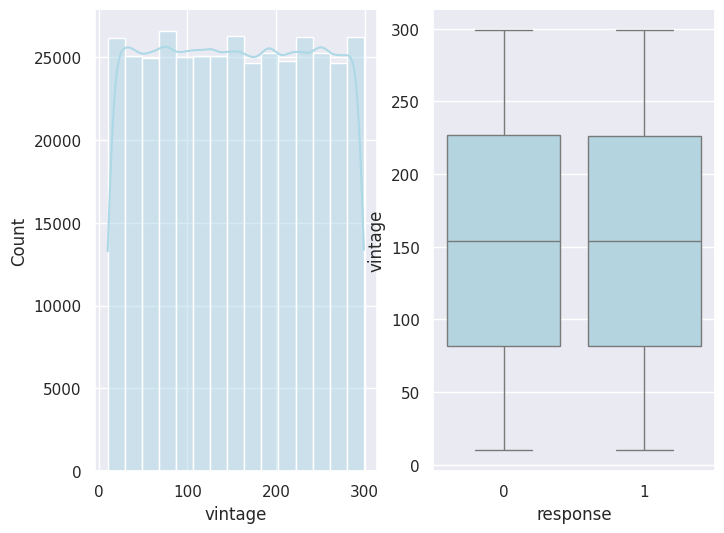

In [21]:
#vintage

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
sns.histplot(df2['vintage'], bins=15, kde=True, color='lightblue', ax=ax[0])
sns.boxplot(x='response', y='vintage', data=df2, color='lightblue', ax=ax[1])

### mesma distribuição. Variável não diz nada ao modelo
---

In [22]:
# gender
df2[['gender', 'response']].value_counts(normalize=True).reset_index()

,gender,response,proportion
0,Male,0,0.465914
1,Female,0,0.411523
2,Male,1,0.074847
3,Female,1,0.047716


### dos que contrataram, a proporção maior é masculina. Para os que não contrataram não há diferença significativa.

# Data Preparation

In [68]:
df3 = df2.copy()

x = df3.drop('response', axis=1)

y = df3['response'].copy()



In [69]:
x_train, x_validation, y_train, y_validation = ms.train_test_split(x, y, test_size=0.25)

df4 = pd.concat([x_train, y_train], axis=1)

In [70]:
x_validation

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
232829,232830,Female,66,1,28.0,0,between_1_2_year,1,47688.0,26.0,98
326219,326220,Male,38,1,28.0,0,between_1_2_year,1,45136.0,109.0,197
124411,124412,Female,49,1,28.0,0,between_1_2_year,1,59932.0,124.0,195
118522,118523,Female,33,1,15.0,0,between_1_2_year,0,35585.0,124.0,291
357436,357437,Male,22,1,10.0,1,below_1_year,0,29561.0,152.0,87
...,...,...,...,...,...,...,...,...,...,...,...
325385,325386,Male,21,1,46.0,1,below_1_year,0,37709.0,152.0,184
171936,171937,Female,44,1,8.0,0,over_2_years,1,40187.0,7.0,152
303200,303201,Male,26,1,41.0,1,below_1_year,1,2630.0,160.0,94
172725,172726,Female,24,1,11.0,1,below_1_year,0,2630.0,152.0,114


## Standardization

In [71]:
# annual_premium

ss = pp.StandardScaler()

df4['annual_premium'] = ss.fit_transform(df4[['annual_premium']].values)
pickle.dump(ss, open('../models/annual_premium_scaler.pkl', 'wb'))

## Rescaling

In [72]:
# age
# mms_age = pp.MinMaxScaler()

# df4['age'] = mms_age.fit_transform(df4[['age']].values)

# #vintage
# mms_vintage= pp.MinMaxScaler()
# df4['vintage'] = mms_age.fit_transform(df4[['vintage']].values)

rs_age = pp.RobustScaler()
rs_vintage = pp.RobustScaler()

df4['age'] = rs_age.fit_transform(df4[['age']].values)
df4['vintage'] = rs_vintage.fit_transform(df4[['vintage']].values)
pickle.dump(rs_age, open('../models/age_scaler.pkl', 'wb'))
pickle.dump(rs_vintage, open('../models/vintage_scaler.pkl', 'wb'))



## Encoder

In [73]:

#gender
targ_enc_gender = df4.groupby('gender')['response'].mean()
df4.loc[:, 'gender'] = df4['gender'].map(targ_enc_gender)
pickle.dump(targ_enc_gender, open('../models/gender_scaler.pkl', 'wb'))

#region_code
targ_enc_region_code = df4.groupby('region_code')['response'].mean()
df4.loc[:, 'region_code'] = df4['region_code'].map(targ_enc_region_code)
pickle.dump(targ_enc_region_code, open('../models/region_code_scaler.pkl', 'wb'))

#vehicle_age
df4 = pd.get_dummies(df4, prefix='vehicle_age', columns=['vehicle_age'], dtype=float)


#policy_sales_channel
targ_enc_policy_sales = df3.groupby('policy_sales_channel').size() / len(df3)
df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map(targ_enc_policy_sales)
pickle.dump(targ_enc_policy_sales, open('../models/policy_sales_scaler.pkl', 'wb'))


In [132]:
df4.head()


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
210514,210515,Male,37,1,33.0,1,between_1_2_year,0,2630.0,124.0,222,0
187407,187408,Female,73,1,28.0,1,between_1_2_year,0,29612.0,26.0,10,0
277263,277264,Male,40,1,8.0,0,between_1_2_year,1,38455.0,124.0,103,0
312470,312471,Male,43,1,31.0,0,between_1_2_year,1,2630.0,124.0,126,1
175030,175031,Female,56,1,50.0,0,between_1_2_year,1,37803.0,124.0,181,0


In [74]:
## Validation preparation
robust_scaler = pp.RobustScaler()
# gender
x_validation.loc[:, 'gender'] = x_validation.loc[:, 'gender'].map(targ_enc_gender)

#age
x_validation['age'] = robust_scaler.fit_transform(x_validation[['age']].values)
#region code
x_validation.loc[:, 'region_code'] = x_validation['region_code'].map(targ_enc_region_code)
#vehicle_age
x_validation = pd.get_dummies(x_validation, prefix='vehicle_age', columns=['vehicle_age'], dtype=float)
#annual_premium
x_validation['annual_premium'] = ss.fit_transform(x_validation[['annual_premium']].values)
#policy_sales_channel
x_validation.loc[:, 'policy_sales_channel'] = x_validation['policy_sales_channel'].map(targ_enc_policy_sales)
#vintage
x_validation['vintage'] = robust_scaler.fit_transform(x_validation[['vintage']].values)
#fillna

In [133]:
x_validation.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage
217724,217725,Male,51,1,8.0,0,between_1_2_year,1,53541.0,25.0,241
27861,27862,Male,24,1,8.0,1,below_1_year,0,28775.0,152.0,126
327596,327597,Female,48,1,28.0,0,between_1_2_year,1,56950.0,26.0,275
289231,289232,Male,48,1,28.0,0,between_1_2_year,1,35254.0,26.0,64
22470,22471,Female,22,1,22.0,0,below_1_year,1,30747.0,152.0,173


In [107]:
x_validation = x_validation.fillna(0)

/tmp/ipykernel_4984/4180648450.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x_validation = x_validation.fillna(0)


## Feature selection

In [75]:
#Usando Features Importancy

forest = en.ExtraTreesClassifier(n_estimators=200, random_state=0, n_jobs=12)

x_train_n = df4.drop(['id', 'response'], axis=1)
y_train_n = y_train.values

forest.fit (x_train_n, y_train_n)



ExtraTreesClassifier(n_estimators=200, n_jobs=12, random_state=0)

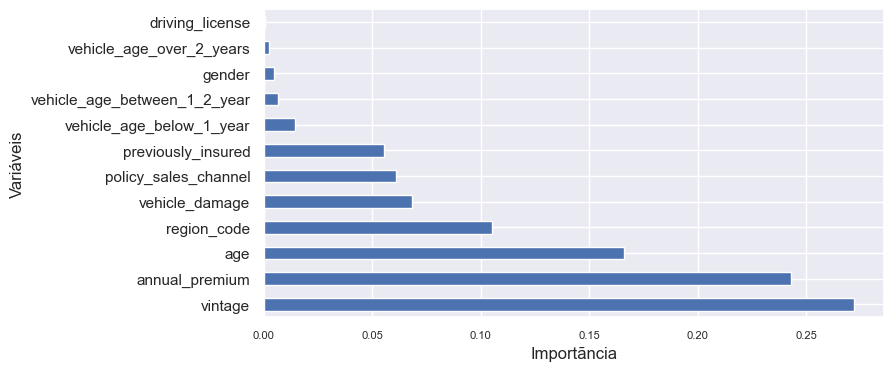

In [77]:
importances = forest.feature_importances_

feature_names = x_train_n.columns

# Convertendo as importâncias em uma série do pandas e associando os nomes dos recursos
importances_series = pd.Series(importances, index=feature_names)

# Ordenando as importâncias de forma decrescente
sorted_importances = importances_series.sort_values(ascending=False)

# Criando o gráfico de barras
plt.figure(figsize=(8, 4))
sorted_importances.plot(kind='barh')
plt.xlabel('Importãncia')
plt.xticks(fontsize=8)
plt.ylabel('Variáveis')
plt.show()

## Machine Learning

In [34]:
cols_selected = ['vintage', 'annual_premium', 'age',
                 'region_code', 'vehicle_damage',
                 'policy_sales_channel', 'previously_insured']

In [35]:
x_train = df4[cols_selected]
x_val = x_validation[cols_selected]
y_val = y_validation.copy()


In [36]:
x_train

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
33335,-0.751724,0.497938,0.250000,0.064655,0,0.194157,1
153683,-0.186207,0.289699,0.416667,0.187304,0,0.194157,1
138138,0.041379,0.148968,-0.375000,0.111589,1,0.194157,0
92056,-0.344828,0.210822,-0.375000,0.123498,0,0.353663,1
45322,-0.620690,1.374561,-0.625000,0.096754,1,0.007591,0
...,...,...,...,...,...,...,...
73140,-0.289655,-1.628821,1.208333,0.084564,0,0.026056,0
212446,1.000000,-1.628821,-0.625000,0.097947,1,0.353663,0
204078,0.227586,0.157421,0.125000,0.097947,0,0.194157,1
284738,0.765517,-0.013508,-0.583333,0.059305,0,0.353663,1


In [138]:
x_val

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured
217724,241,53541.0,51,8.0,1,25.0,0
27861,126,28775.0,24,8.0,0,152.0,1
327596,275,56950.0,48,28.0,1,26.0,0
289231,64,35254.0,48,28.0,1,26.0,0
22470,173,30747.0,22,22.0,1,152.0,0
...,...,...,...,...,...,...,...
259309,246,22377.0,25,50.0,0,152.0,1
355166,218,29925.0,24,8.0,1,151.0,0
66794,112,31705.0,21,30.0,1,152.0,1
120567,27,2630.0,58,3.0,1,156.0,0


In [41]:
#model definition

knn_model = nh.KNeighborsClassifier(n_neighbors=18, n_jobs=12)

#model training
knn_model.fit(x_train, y_train)

#model prediction - poder de generalização 
yhat_knn = knn_model.predict_proba(x_val)

# skplt.metrics.plot_cumulative_gain (y_val, yhat_knn)
# skplt.metrics.plot_lift_curve(y_val, yhat_knn)


In [42]:
#Logistic Regression

lr_model = lm.LogisticRegression(random_state=42, penalty='l2', C=1)

lr_model.fit(x_train, y_train)

yhat_lr = lr_model.predict_proba(x_val)

# skplt.metrics.plot_cumulative_gain (y_val, yhat_lr)
# skplt.metrics.plot_lift_curve(y_val, yhat_lr)


In [43]:
#Randon Forest

rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=8, min_samples_leaf=5 , n_jobs=12)

rf_model.fit(x_train, y_train)

yhat_rf = rf_model.predict_proba(x_val)
yhat_rf2 = rf_model.predict(x_val)

# skplt.metrics.plot_cumulative_gain (y_val, yhat_rf)
# skplt.metrics.plot_roc(y_val, yhat_rf)
# skplt.metrics.plot_lift_curve(y_val, yhat_rf)

accuracy = mt.accuracy_score(y_val, yhat_rf2)
recall = mt.recall_score(y_val, yhat_rf2)
f1 = mt.f1_score(y_val, yhat_rf2)
roc_auc = mt.roc_auc_score(y_val, yhat_rf[:, 1])


In [44]:
#Light Boost Gradient Classifier

lgbm_model = LGBMClassifier(n_jobs=12, verbose=0)

lgbm_model.fit(x_train, y_train)

yhat_lgbm = lgbm_model.predict_proba(x_val)
yhat_lgbm2 = lgbm_model.predict(x_val)

# skplt.metrics.plot_cumulative_gain (y_val, yhat_lgbm)
# skplt.metrics.plot_roc(y_val, yhat_lgbm)
# skplt.metrics.plot_lift_curve(y_val, yhat_lgbm)

accuracy = mt.accuracy_score(y_val, yhat_lgbm2)
recall = mt.recall_score(y_val, yhat_lgbm2)
f1 = mt.f1_score(y_val, yhat_lgbm2)
roc_auc = mt.roc_auc_score(y_val, yhat_lgbm[:, 1])

print("Acurácia:", accuracy)
print("Revocação:", recall)
print("Pontuação F1:", f1)
print("ROC-AUC:", roc_auc)

Acurácia: 0.8781355611998573
Revocação: 0.0024148339801638636
Pontuação F1: 0.004799862861061112
ROC-AUC: 0.8551352326414561


In [45]:
#Gradient boosting classifier

gbc_model  = en.HistGradientBoostingClassifier()

gbc_model.fit(x_train, y_train)

yhat_gbc = gbc_model.predict_proba(x_val)
yhat_gbc2 = gbc_model.predict(x_val)

# skplt.metrics.plot_cumulative_gain (y_val, yhat_gbc)
# skplt.metrics.plot_roc(y_val, yhat_gbc)
# skplt.metrics.plot_lift_curve(y_val, yhat_gbc)

accuracy = mt.accuracy_score(y_val, yhat_gbc2)
recall = mt.recall_score(y_val, yhat_gbc2)
f1 = mt.f1_score(y_val, yhat_gbc2)
roc_auc = mt.roc_auc_score(y_val, yhat_gbc[:, 1])

print("Acurácia:", accuracy)
print("Revocação:", recall)
print("Pontuação F1:", f1)
print("ROC-AUC:", roc_auc)

Acurácia: 0.8781775436092277
Revocação: 0.000689952565761104
Pontuação F1: 0.0013765809171470361
ROC-AUC: 0.8543382456217592


# Model Performance at K

In [46]:
# # KNN Performance

# df5 = x_val.copy()
# df5['response'] = y_val.copy()

# # propensity score
# df5['score'] = yhat_knn[:, 1].tolist()

# # sort clients by propensity score
# df5 = df5.sort_values( 'score', ascending=False )

# # compute precision at k 
# precision_at_knn = precision_at_k(df5,0.2)
# print('precision_at_k: {}'.format(precision_at_knn))

# # compute recall at k
# recall_at_knn = recall_at_k(df5,0.2)
# print('recall_at_k: {}'.format(recall_at_knn))

# roc_auc_knn = mt.roc_auc_score(y_val, yhat_knn[:,1])
# print('ROC AUC Score: {}'.format(roc_auc_knn))

# aux1 = metrics('KNN Classifier', precision_at_knn,recall_at_knn,roc_auc_knn)
# aux1

metrics_knn = calculateMetrics('KNN Classifier', yhat_knn, x_val, y_val)
metrics_knn


,Model Name,Precision_at_k,Recall_at_k,Roc_auc
0,KNN Classifier,0.314179,0.516343,0.823586


In [47]:
# Logistic Regression Classifier

metrics_lr = calculateMetrics('Log Regression', yhat_lr, x_val, y_val)
metrics_lr

,Model Name,Precision_at_k,Recall_at_k,Roc_auc
0,Log Regression,0.288308,0.473825,0.81929


In [48]:
# Random Forest Classifier

metrics_rf = calculateMetrics('Random Forest', yhat_rf, x_val, y_val)
metrics_rf


,Model Name,Precision_at_k,Recall_at_k,Roc_auc
0,Random Forest,0.336902,0.553687,0.848174


In [49]:
# LGBM Classifier

metric_lgbm = calculateMetrics('LGBM Classifier', yhat_lgbm, x_val, y_val)
metric_lgbm

,Model Name,Precision_at_k,Recall_at_k,Roc_auc
0,LGBM Classifier,0.348814,0.573264,0.855135


In [50]:
metric_gbc = calculateMetrics('Hist Grad Boosting Classifier', yhat_gbc, x_val, y_val)
metric_gbc

,Model Name,Precision_at_k,Recall_at_k,Roc_auc
0,Hist Grad Boosting Classifier,0.347817,0.571626,0.854338


In [51]:
all_metrics = pd.concat([metrics_knn, metrics_lr, metrics_rf, metric_lgbm, metric_gbc])

all_metrics

,Model Name,Precision_at_k,Recall_at_k,Roc_auc
0,KNN Classifier,0.314179,0.516343,0.823586
0,Log Regression,0.288308,0.473825,0.819290
0,Random Forest,0.336902,0.553687,0.848174
0,LGBM Classifier,0.348814,0.573264,0.855135
0,Hist Grad Boosting Classifier,0.347817,0.571626,0.854338


In [150]:
df5 = x_val.copy()
df5['response'] = y_val.copy()

# propensity score
df5['score'] = yhat_lgbm[:, 1].tolist()
# sort clients by propensity score
df5 = df5.sort_values( 'score', ascending=False )

df5.sample(20)

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured,response,score
2243,156,34115.0,43,28.0,0,26.0,1,0,0.000343
305408,179,31544.0,25,11.0,0,152.0,1,0,0.000021
288069,49,28476.0,49,28.0,0,124.0,1,0,0.000170
52188,281,55701.0,58,28.0,1,124.0,0,0,0.221310
11959,228,43057.0,58,28.0,1,26.0,0,0,0.301127
98530,137,2630.0,46,43.0,1,30.0,0,0,0.269567
356505,224,28121.0,42,35.0,0,124.0,1,0,0.000171
258788,103,2630.0,23,29.0,1,157.0,0,1,0.179950
36331,47,33705.0,23,50.0,0,152.0,1,0,0.000014
134813,254,35765.0,22,17.0,1,152.0,0,0,0.084149


# Cross Validation - LGBM

In [151]:
#LGBM

cv_scores_lgbm = cross_val_score(lgbm_model, x_train, y_train, cv=5, scoring='roc_auc')

mean_cv_score_lgbm = np.mean(cv_scores_lgbm)

print("Scores de cross-validation LGBM:", cv_scores_lgbm)
print("Média dos scores de cross-validation LGBM:", mean_cv_score_lgbm)

#Random Forest

cv_scores_rf = cross_val_score(rf_model, x_train, y_train, cv=5, scoring='roc_auc')

mean_cv_score_rf = np.mean(cv_scores_rf)

print("Scores de cross-validation RF:", cv_scores_rf)
print("Média dos scores de cross-validation RF:", mean_cv_score_rf)

Scores de cross-validation LGBM: [0.85323418 0.85406581 0.85610412 0.85588165 0.85503391]
Média dos scores de cross-validation LGBM: 0.8548639310885544
Scores de cross-validation RF: [0.84639925 0.84707793 0.84818687 0.84790831 0.84771337]
Média dos scores de cross-validation RF: 0.8474571474520071


In [152]:
with open('../models/lgbm_model.pkl', 'wb') as file:
    pickle.dump(lgbm_model, file)

In [153]:
with open('../models/rf_model.pkl', 'wb') as file:
    pickle.dump(rf_model, file, 3)

# Classe HealthInsurance

In [54]:
import pandas as pd
import numpy as np
import pickle

class healthInsurance:
    def __init__(self):
        self.home_path = ''
        self.annual_premium_scaler = pickle.load(open ('..models/annual_premium_scaler.pkl', 'rb'))
        self.age_scaler = pickle.load(open ('..models/age_scaler.pkl', 'rb'))
        self.vintage_scaler = pickle.load(open ('..models/vintage_scaler.pkl', 'rb'))
        self.gender_scaler = pickle.load(open ('..models/gender_scaler', 'rb'))
        self.region_code_scaler = pickle.load(open ('..models/region_code_scaler.pkl', 'rb'))
        self.policy_sales_scaler = pickle.load(open ('..models/policy_sales_scaler.pkl', 'rb'))
    
    def data_cleaning (self, df1):
        news_cols = ['id', 'gender', 'age', 'driving_license', 'region_code',
       'previously_insured', 'vehicle_age', 'vehicle_damage', 'annual_premium',
       'policy_sales_channel', 'vintage', 'response']

        df1.columns = news_cols
        return df1
    
    def feature_engineering (self, df2):
        df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x== '> 2 Years'
                                            else 'between_1_2_year' if x == '1-2 Year'
                                            else 'below_1_year' )

        df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)
        return df2
    
    def data_preparation(self, df4):
        df4['annual_premium'] = self.annual_premium_scaler.transform(df4[['annual_premium']].values)
        
        df4['age'] = self.age_scaler.tranform(df4[['age']].values)
        df4['vintage'] = self.vintage_scaler.transform(df4[['vintage']].values)
        
        df4.loc[:, 'gender'] = df4['gender'].map(self.gender_scaler)
        
        df4.loc[:, 'region_code'] = df4['region_code'].map(self.region_code_scaler)
          
        df4 = pd.get_dummies(df4, prefix='vehicle_age', columns=['vehicle_age'], dtype=float)
                
        df4.loc[:, 'policy_sales_channel'] = df4['policy_sales_channel'].map(self.policy_sales_scaler)
        
        cols_selected = ['vintage', 'annual_premium', 'age',
                        'region_code', 'vehicle_damage',
                        'policy_sales_channel', 'previously_insured']
        return df4[ cols_selected]
    
    def get_prediction (self, model, original_data, test_data):
        
        pred = model.predict_proba(test_data)
        
        original_data['score'] = pred
        
        return original_data.to_json(orient='records', date_format='iso')
                 

# API Handler

In [55]:
import pickle
import pandas as pd
from flask import Flask, request, Response
# from healthinsurance import HealthInsurance

#loading model
model = pickle.load(open('../models/lgbm_model.pkl', 'rb'))

#initialize API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: #there´s data
        if isinstance(test_json, dict): #unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: #multiple examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        #instantiate healthinsurance class
        pipeline = healthInsurance()
        
        #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        #data preparation
        df3 = pipeline.data_preparation(df2)
        
        #prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    else:
        
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    app.run('0.0.0.0', port=3500, debug=True)
            

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:3500
 * Running on http://172.23.167.223:3500
Press CTRL+C to quit
 * Restarting with stat
0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/junicoletti/.pyenv/versions/3.11.8/envs/health_insurance/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/junicoletti/.pyenv/versions/3.11.8/envs/health_insurance/lib/python3.11/site-packages/traitlets/config/application.py", line 1074, in launch_instance
    app.initialize(argv)
  File "/home/junicoletti/.pye

SystemExit: 1

/home/junicoletti/.pyenv/versions/3.11.8/envs/health_insurance/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# API Tester

In [154]:
import requests
import json

#loading test dataset

df_test = x_validation
df_test['response'] = y_validation


df_test



,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
217724,217725,Male,51,1,8.0,0,between_1_2_year,1,53541.0,25.0,241,0
27861,27862,Male,24,1,8.0,1,below_1_year,0,28775.0,152.0,126,0
327596,327597,Female,48,1,28.0,0,between_1_2_year,1,56950.0,26.0,275,1
289231,289232,Male,48,1,28.0,0,between_1_2_year,1,35254.0,26.0,64,1
22470,22471,Female,22,1,22.0,0,below_1_year,1,30747.0,152.0,173,0
...,...,...,...,...,...,...,...,...,...,...,...,...
259309,259310,Female,25,1,50.0,1,below_1_year,0,22377.0,152.0,246,0
355166,355167,Female,24,1,8.0,0,below_1_year,1,29925.0,151.0,218,0
66794,66795,Female,21,1,30.0,1,below_1_year,1,31705.0,152.0,112,0
120567,120568,Female,58,1,3.0,0,between_1_2_year,1,2630.0,156.0,27,0


In [155]:
model_test = pickle.load(open('../models/lgbm_model.pkl', 'rb'))
df_test2 = df_test[cols_selected]
pred = model_test.predict_proba(df_test2.head(15))
pred

array([[7.10955736e-01, 2.89044264e-01],
       [9.99974405e-01, 2.55947296e-05],
       [6.13161868e-01, 3.86838132e-01],
       [6.26187860e-01, 3.73812140e-01],
       [8.90491419e-01, 1.09508581e-01],
       [7.94254049e-01, 2.05745951e-01],
       [9.99947297e-01, 5.27031438e-05],
       [9.99949862e-01, 5.01382328e-05],
       [8.36217202e-01, 1.63782798e-01],
       [9.99955831e-01, 4.41686551e-05],
       [9.62135247e-01, 3.78647534e-02],
       [9.99958830e-01, 4.11698110e-05],
       [9.99843148e-01, 1.56852299e-04],
       [6.13161868e-01, 3.86838132e-01],
       [9.99946033e-01, 5.39668359e-05]])

In [156]:
df_test.head(15)


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
217724,217725,Male,51,1,8.0,0,between_1_2_year,1,53541.0,25.0,241,0
27861,27862,Male,24,1,8.0,1,below_1_year,0,28775.0,152.0,126,0
327596,327597,Female,48,1,28.0,0,between_1_2_year,1,56950.0,26.0,275,1
289231,289232,Male,48,1,28.0,0,between_1_2_year,1,35254.0,26.0,64,1
22470,22471,Female,22,1,22.0,0,below_1_year,1,30747.0,152.0,173,0
379938,379939,Female,61,1,33.0,0,between_1_2_year,1,36456.0,124.0,220,0
142627,142628,Male,24,1,28.0,1,below_1_year,0,46688.0,152.0,255,0
381069,381070,Male,24,1,8.0,1,below_1_year,0,38254.0,152.0,127,0
75481,75482,Female,57,1,24.0,0,between_1_2_year,0,2630.0,157.0,114,0
90475,90476,Male,28,1,13.0,1,below_1_year,0,11600.0,152.0,142,0


In [199]:
#convert dt to json
data = json.dumps(df_test.sample(25).to_dict(orient='records'))


In [193]:
data

'[{"id": 249867, "gender": "Female", "age": 24, "driving_license": 1, "region_code": 10.0, "previously_insured": 1, "vehicle_age": "below_1_year", "vehicle_damage": 0, "annual_premium": 32501.0, "policy_sales_channel": 152.0, "vintage": 268, "response": 0}, {"id": 361105, "gender": "Female", "age": 55, "driving_license": 1, "region_code": 8.0, "previously_insured": 1, "vehicle_age": "between_1_2_year", "vehicle_damage": 0, "annual_premium": 30773.0, "policy_sales_channel": 26.0, "vintage": 123, "response": 0}, {"id": 100110, "gender": "Female", "age": 42, "driving_license": 1, "region_code": 46.0, "previously_insured": 0, "vehicle_age": "between_1_2_year", "vehicle_damage": 1, "annual_premium": 25075.0, "policy_sales_channel": 124.0, "vintage": 259, "response": 0}, {"id": 202123, "gender": "Female", "age": 24, "driving_license": 1, "region_code": 45.0, "previously_insured": 0, "vehicle_age": "below_1_year", "vehicle_damage": 1, "annual_premium": 16269.0, "policy_sales_channel": 152.0, 

In [200]:
#API call
url = ' https://health-insurance-app-vaom.onrender.com/predict'

header = {'Content-type' : 'application/json'}

r = requests.post(url, data=data, headers = header)
print(f'Status Code {r.status_code}')


Status Code 200


In [201]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.sort_values('score', ascending = False)


,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,score
20,20584,Male,48,1,28.0,0,between_1_2_year,1,56333.0,26.0,238,0,0.365109
6,80813,Female,34,1,33.0,0,between_1_2_year,1,32574.0,124.0,267,0,0.346928
21,62127,Female,37,1,13.0,0,between_1_2_year,1,25555.0,157.0,167,0,0.336307
9,326778,Male,36,1,26.0,0,between_1_2_year,1,28982.0,124.0,216,0,0.336258
7,176470,Male,37,1,28.0,0,between_1_2_year,1,39379.0,124.0,283,0,0.333497
17,81490,Male,51,1,35.0,0,between_1_2_year,1,26674.0,26.0,102,0,0.313667
5,8566,Female,44,1,28.0,0,over_2_years,1,34555.0,124.0,138,1,0.309079
15,241994,Male,43,1,15.0,0,between_1_2_year,1,25166.0,14.0,76,0,0.306064
14,17678,Female,34,1,46.0,0,between_1_2_year,1,2630.0,157.0,92,0,0.289565
8,304085,Male,49,1,28.0,0,between_1_2_year,1,41914.0,124.0,62,0,0.282004


In [202]:
d1.describe().T

,count,mean,std,min,25%,50%,75%,max
id,25.0,170425.880000,116648.550255,8566.00000,80813.000000,166803.000000,292200.000000,354949.000000
age,25.0,39.720000,16.218611,20.00000,25.000000,37.000000,48.000000,76.000000
driving_license,25.0,1.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000
region_code,25.0,26.920000,12.044778,1.00000,24.000000,28.000000,33.000000,50.000000
previously_insured,25.0,0.320000,0.476095,0.00000,0.000000,0.000000,1.000000,1.000000
vehicle_damage,25.0,0.640000,0.489898,0.00000,0.000000,1.000000,1.000000,1.000000
annual_premium,25.0,32965.760000,18351.829823,2630.00000,25555.000000,31414.000000,41914.000000,70225.000000
policy_sales_channel,25.0,119.760000,50.928283,14.00000,124.000000,152.000000,152.000000,160.000000
vintage,25.0,154.800000,85.518029,12.00000,92.000000,134.000000,238.000000,288.000000
response,25.0,0.040000,0.200000,0.00000,0.000000,0.000000,0.000000,1.000000
